In [1]:
import numpy as np
if not hasattr(np, "object"):
    np.object = object


/tmp/ipykernel_1274/1078063041.py:2: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [2]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("tweet_eval", "emotion")
train_dataset = dataset["train"]
val_dataset = dataset["validation"]
test_dataset = dataset["test"]

Reusing dataset tweet_eval (/home/sagemaker-user/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotion_labels = {
    0: "anger",
    1: "joy",
    2: "optimism",
    3: "sadness"
}
id_to_label = {i: label for i, label in emotion_labels.items()}
label_to_id = {label: i for i, label in emotion_labels.items()}

print(f"Train: {len(train_dataset):,}")
print(f"Val: {len(val_dataset):,}")
print(f"Test: {len(test_dataset):,}")
print(f"Total emotion classes: {len(emotion_labels)}")
print(f"Emotion labels: {list(emotion_labels.values())}")


Train: 3,257
Val: 374
Test: 1,421
Total emotion classes: 4
Emotion labels: ['anger', 'joy', 'optimism', 'sadness']


In [4]:
import torch
import os
from datetime import datetime

class Config:
    def __init__(self):
        self.base_model = "microsoft/deberta-v3-base"
        self.num_emotions = 4
        self.max_length = 256
        self.hidden_dropout = 0.3
        self.attention_dropout = 0.15
        self.batch_size = 16
        self.learning_rate = 2e-5
        self.num_epochs = 5
        self.warmup_ratio = 0.1
        self.weight_decay = 0.01
        self.gradient_clip = 1.0
        self.model_save_path = "./models/tweeteval"
        self.results_path = "./results/tweeteval"
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.num_workers = 2 if torch.cuda.is_available() else 0

        os.makedirs(self.model_save_path, exist_ok=True)
        os.makedirs(self.results_path, exist_ok=True)

config = Config()
print(f"Using device: {config.device}")
print(f"Model: {config.base_model}")
print(f"Configuration saved to: {config.model_save_path}")


Using device: cuda
Model: microsoft/deberta-v3-base
Configuration saved to: ./models/tweeteval


In [5]:
import torch
from torch.utils.data import Dataset
from typing import List
import re

class TweetEvalDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_length: int = 256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx]).strip()

        text = self._preprocess_text(text)

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

    def _preprocess_text(self, text: str) -> str:
        text = re.sub(r'http\S+|www\S+|https\S+', '[URL]', text, flags=re.MULTILINE)
        text = re.sub(r'\s+', ' ', text)
        return text.strip()

In [6]:
import torch.nn as nn
from transformers import AutoModel

class GoEmotionsModel(nn.Module):
    def __init__(self, config):
        super(GoEmotionsModel, self).__init__()
        self.config = config

        self.backbone = AutoModel.from_pretrained(config.base_model)
        hidden_size = self.backbone.config.hidden_size

        self.attention_pooling = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=12,
            dropout=config.attention_dropout,
            batch_first=True
        )

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.LayerNorm(hidden_size // 2),
            nn.GELU(),
            nn.Dropout(config.hidden_dropout),
            nn.Linear(hidden_size // 2, config.num_emotions)
        )

        self._init_weights()

    def _init_weights(self):
        for module in self.classifier:
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        cls_output = hidden_states[:, 0, :]

        attended_output, _ = self.attention_pooling(hidden_states, hidden_states, hidden_states)
        mean_attended = attended_output.mean(dim=1)

        combined = torch.cat([cls_output, mean_attended], dim=1)

        logits = self.classifier(combined)
        return logits

In [9]:
import logging
from typing import Dict, Tuple, List
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm
import json
import os
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
logger = logging.getLogger(__name__)

class TweetEvalTrainer:
    def __init__(self, config):
        self.config = config
        self.logger = logging.getLogger(__name__)
        self.tokenizer = None
        self.model = None
        self.optimizer = None
        self.scheduler = None
        self.criterion = None
        self.history = {
            'train_loss': [],
            'train_accuracy': [],
            'train_f1': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1_macro': [],
            'val_f1_weighted': []
        }

    def load_data(self, train_dataset, val_dataset, test_dataset) -> Tuple[Dataset, Dataset, Dataset]:
        self.tokenizer = AutoTokenizer.from_pretrained(self.config.base_model)

        train_texts = [example['text'] for example in train_dataset]
        train_labels = [example['label'] for example in train_dataset]

        val_texts = [example['text'] for example in val_dataset]
        val_labels = [example['label'] for example in val_dataset]

        test_texts = [example['text'] for example in test_dataset]
        test_labels = [example['label'] for example in test_dataset]

        train_ds = TweetEvalDataset(train_texts, train_labels, self.tokenizer, self.config.max_length)
        val_ds = TweetEvalDataset(val_texts, val_labels, self.tokenizer, self.config.max_length)
        test_ds = TweetEvalDataset(test_texts, test_labels, self.tokenizer, self.config.max_length)

        return train_ds, val_ds, test_ds

    def setup_model(self):
        self.model = GoEmotionsModel(self.config).to(self.config.device)
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=self.config.learning_rate,
            weight_decay=self.config.weight_decay,
            eps=1e-8
        )
        self.criterion = nn.CrossEntropyLoss()

        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print(f"Model parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")

    def create_scheduler(self, train_dataloader):
        total_steps = len(train_dataloader) * self.config.num_epochs
        warmup_steps = int(total_steps * self.config.warmup_ratio)
        self.scheduler = get_linear_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")

    def train_epoch(self, train_dataloader) -> Tuple[float, float, float]:
        self.model.train()
        total_loss = 0
        all_predictions = []
        all_labels = []

        for batch in tqdm(train_dataloader, desc="Training", leave=False):
            input_ids = batch['input_ids'].to(self.config.device)
            attention_mask = batch['attention_mask'].to(self.config.device)
            labels = batch['labels'].to(self.config.device)

            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)
            self.optimizer.step()
            self.scheduler.step()

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=-1)
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(train_dataloader)
        accuracy = accuracy_score(all_labels, all_predictions)
        f1_score = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')[2]

        return avg_loss, accuracy, f1_score

    def evaluate(self, val_dataloader) -> Dict[str, float]:
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Evaluating", leave=False):
                input_ids = batch['input_ids'].to(self.config.device)
                attention_mask = batch['attention_mask'].to(self.config.device)
                labels = batch['labels'].to(self.config.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)
                total_loss += loss.item()

                predictions = torch.argmax(logits, dim=-1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_dataloader)
        accuracy = accuracy_score(all_labels, all_predictions)

        precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='macro', zero_division=0
        )
        precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
            all_labels, all_predictions, average='weighted', zero_division=0
        )

        precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
            all_labels, all_predictions, average=None, zero_division=0
        )

        return {
            'loss': avg_loss,
            'accuracy': accuracy,
            'precision_macro': precision_macro,
            'recall_macro': recall_macro,
            'f1_macro': f1_macro,
            'precision_weighted': precision_weighted,
            'recall_weighted': recall_weighted,
            'f1_weighted': f1_weighted,
            'predictions': all_predictions,
            'labels': all_labels,
            'precision_per_class': precision_per_class.tolist(),
            'recall_per_class': recall_per_class.tolist(),
            'f1_per_class': f1_per_class.tolist(),
            'support_per_class': support_per_class.tolist()
        }

    def train(self, train_ds: Dataset, val_ds: Dataset):
        train_dataloader = DataLoader(
            train_ds,
            batch_size=self.config.batch_size,
            shuffle=True,
            num_workers=self.config.num_workers,
            pin_memory=True
        )

        val_dataloader = DataLoader(
            val_ds,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers,
            pin_memory=True
        )

        self.setup_model()
        self.create_scheduler(train_dataloader)

        best_f1 = 0.0
        patience = 3
        no_improve = 0

        print(f"\nStarting Training")
        print(f"Training batches: {len(train_dataloader)}")
        print(f"Validation batches: {len(val_dataloader)}")

        for epoch in range(self.config.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")

            train_loss, train_acc, train_f1 = self.train_epoch(train_dataloader)
            val_metrics = self.evaluate(val_dataloader)

            self.history['train_loss'].append(train_loss)
            self.history['train_accuracy'].append(train_acc)
            self.history['train_f1'].append(train_f1)
            self.history['val_loss'].append(val_metrics['loss'])
            self.history['val_accuracy'].append(val_metrics['accuracy'])
            self.history['val_f1_macro'].append(val_metrics['f1_macro'])
            self.history['val_f1_weighted'].append(val_metrics['f1_weighted'])

            print(f"Train Loss      : {train_loss:.4f}")
            print(f"Train Accuracy  : {train_acc*100:.2f}%")
            print(f"Train F1        : {train_f1:.4f}")
            print(f"Val Loss        : {val_metrics['loss']:.4f}")
            print(f"Val Accuracy    : {val_metrics['accuracy']*100:.2f}%")
            print(f"Val F1 Macro    : {val_metrics['f1_macro']:.4f}")
            print(f"Val F1 Weighted : {val_metrics['f1_weighted']:.4f}")

            if val_metrics['f1_weighted'] > best_f1:
                best_f1 = val_metrics['f1_weighted']
                no_improve = 0
                self.save_model('best_model.pt', val_metrics)
                print("Best model saved")
            else:
                no_improve += 1
                if no_improve >= patience:
                    print("Early stopping triggered")
                    break

        final_val_metrics = self.evaluate(val_dataloader)
        self.save_model('final_model.pt', final_val_metrics)
        print(f"Training completed. Best validation F1: {best_f1:.4f}")

    def save_model(self, filename: str, metrics: Dict = None):
        filepath = os.path.join(self.config.model_save_path, filename)
        
        torch.save(self.model.state_dict(), filepath)
        
        try:
            self.tokenizer.save_pretrained(self.config.model_save_path)
        except Exception as e:
            print(f"Tokenizer save failed: {e}")
        
        print(f"Model weights saved to: {filepath}")
        
        if metrics:
            metrics_path = filepath.replace('.pt', '_metrics.json')
            with open(metrics_path, 'w') as f:
                clean_metrics = {k: v for k, v in metrics.items() 
                               if k not in ['predictions', 'labels', 'precision_per_class', 
                                          'recall_per_class', 'f1_per_class', 'support_per_class']}
                json.dump(clean_metrics, f, indent=2, default=str)
            print(f"Metrics saved to: {metrics_path}")



    def load_model(self, path, strict_loading=True, exclude_classifier=False):
        if os.path.isabs(path) or os.path.exists(path):
            filepath = path
        else:
            filepath = os.path.join(self.config.model_save_path, path)
    
        if not os.path.exists(filepath):
            print(f"[!] No checkpoint found at {filepath}")
            return False
    
        checkpoint = torch.load(filepath, map_location=self.config.device)
        model_state_dict = checkpoint.get("model_state_dict", checkpoint)
    
        if exclude_classifier:
            filtered_state_dict = {}
            classifier_keys = []
            for key, value in model_state_dict.items():
                if 'classifier' in key:
                    classifier_keys.append(key)
                else:
                    filtered_state_dict[key] = value
            
            model_state_dict = filtered_state_dict
            if classifier_keys:
                print(f"Excluded classifier keys: {len(classifier_keys)} parameters")
                print(f"Classifier keys excluded: {classifier_keys[:3]}...")
    
        load_result = self.model.load_state_dict(model_state_dict, strict=strict_loading)
        if isinstance(load_result, tuple):
            missing_keys, unexpected_keys = load_result
        else:
            missing_keys, unexpected_keys = load_result.missing_keys, load_result.unexpected_keys
    
        print(f"Model loaded from: {filepath}")
        if missing_keys:
            print(f"Missing keys: {len(missing_keys)} (expected for different classifier)")
        if unexpected_keys:
            print(f"Unexpected keys: {unexpected_keys}")
    
        return True

    def load_pretrained_weights(self, model_path: str, strict: bool = False, exclude_classifier: bool = True):
        print(f"Attempting to load pretrained weights from: {model_path}")
    
        if not os.path.exists(model_path):
            print(f"Pretrained model file not found at: {model_path}")
            return False
    
        if self.model is None:
            print("Model not initialized. Call setup_model() first.")
            return False
    
        success = self.load_model(model_path, strict_loading=strict, exclude_classifier=exclude_classifier)
    
        if success:
            print("Pretrained backbone weights loaded successfully for fine-tuning")
            print("Classifier layer will be trained from scratch")
        else:
            print("Failed to load pretrained weights, continuing with base model")
    
        return success


    def _verify_weight_loading(self, old_state_dict, new_state_dict):
        changed_params = 0
        total_params = 0
        param_differences = []

        for key in new_state_dict.keys():
            if key in old_state_dict:
                old_param = old_state_dict[key]
                new_param = new_state_dict[key]

                if not torch.equal(old_param, new_param):
                    changed_params += 1
                    diff_norm = torch.norm(new_param - old_param).item()
                    param_differences.append((key, diff_norm))

                total_params += 1

        print(f"Parameters changed: {changed_params}/{total_params}")

        if param_differences:
            param_differences.sort(key=lambda x: x[1], reverse=True)
            print("Top parameter changes:")
            for i, (param_name, diff) in enumerate(param_differences[:5]):
                print(f"  {param_name}: {diff:.6f}")

        return changed_params > 0 and changed_params <= total_params

    def load_pretrained_weights(self, model_path: str, strict: bool = False, exclude_classifier: bool = True):
        print(f"Attempting to load pretrained weights from: {model_path}")
    
        if not os.path.exists(model_path):
            print(f"Pretrained model file not found at: {model_path}")
            return False
    
        if self.model is None:
            print("Model not initialized. Call setup_model() first.")
            return False
    
        success = self.load_model(model_path, strict_loading=strict, exclude_classifier=exclude_classifier)
    
        if success:
            print("Pretrained backbone weights loaded successfully for fine-tuning")
            if exclude_classifier:
                print("Classifier layer will be trained from scratch")
        else:
            print("Failed to load pretrained weights, continuing with base model")
    
        return success

    def test(self, test_ds: Dataset, emotion_labels: Dict) -> Dict[str, float]:
        test_dataloader = DataLoader(
            test_ds,
            batch_size=self.config.batch_size,
            shuffle=False,
            num_workers=self.config.num_workers
        )

        print("Running test evaluation")
        test_metrics = self.evaluate(test_dataloader)

        emotion_names = [emotion_labels[i] for i in range(len(emotion_labels))]
        class_report = classification_report(
            test_metrics['labels'],
            test_metrics['predictions'],
            target_names=emotion_names,
            output_dict=True
        )

        conf_matrix = confusion_matrix(
            test_metrics['labels'],
            test_metrics['predictions']
        )

        test_metrics['classification_report'] = class_report
        test_metrics['confusion_matrix'] = conf_matrix.tolist()

        return test_metrics

    def predict(self, texts: List[str], emotion_labels: Dict) -> List[Dict[str, float]]:
        self.model.eval()
        results = []

        with torch.no_grad():
            for text in texts:
                encoding = self.tokenizer(
                    text,
                    truncation=True,
                    padding='max_length',
                    max_length=self.config.max_length,
                    return_tensors='pt'
                ).to(self.config.device)

                logits = self.model(encoding['input_ids'], encoding['attention_mask'])
                probabilities = torch.softmax(logits, dim=-1).cpu().numpy()[0]
                predicted_class = np.argmax(probabilities)

                predictions = {
                    'predicted_emotion': emotion_labels[predicted_class],
                    'confidence': float(probabilities[predicted_class]),
                    'all_probabilities': {emotion_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
                }
                results.append(predictions)

        return results

In [10]:
trainer = TweetEvalTrainer(config)
train_ds, val_ds, test_ds = trainer.load_data(train_dataset, val_dataset, test_dataset)
trainer.setup_model()

pretrained_model_path = "./final_model.pt" 

if os.path.exists(pretrained_model_path):
    trainer.load_pretrained_weights(pretrained_model_path, strict=False)
else:
    print("No pretrained model found, starting with base pretrained weights")

print("Starting fine-tuning on TweetEval")
trainer.train(train_ds, val_ds)


/opt/conda/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


Model parameters: 187,673,476
Trainable parameters: 187,673,476
Attempting to load pretrained weights from: ./final_model.pt
Excluded classifier keys: 10 parameters
Classifier keys excluded: ['classifier.0.weight', 'classifier.0.bias', 'classifier.1.weight']...
Model loaded from: ./final_model.pt
Missing keys: 10 (expected for different classifier)
Unexpected keys: ['layer_norm.weight', 'layer_norm.bias']
Pretrained backbone weights loaded successfully for fine-tuning
Classifier layer will be trained from scratch
Starting fine-tuning on TweetEval
Model parameters: 187,673,476
Trainable parameters: 187,673,476
Total training steps: 1020
Warmup steps: 102

Starting Training
Training batches: 204
Validation batches: 24

Epoch 1/5


Train Loss      : 1.3878
Train Accuracy  : 38.56%
Train F1        : 0.3550
Val Loss        : 0.7708
Val Accuracy    : 74.60%
Val F1 Macro    : 0.5681
Val F1 Weighted : 0.7140
Model weights saved to: ./models/tweeteval/best_model.pt
Metrics saved to: ./models/tweeteval/best_model_metrics.json
Best model saved

Epoch 2/5


Train Loss      : 0.7444
Train Accuracy  : 74.46%
Train F1        : 0.7358
Val Loss        : 0.4757
Val Accuracy    : 83.16%
Val F1 Macro    : 0.7614
Val F1 Weighted : 0.8286
Model weights saved to: ./models/tweeteval/best_model.pt
Metrics saved to: ./models/tweeteval/best_model_metrics.json
Best model saved

Epoch 3/5


Train Loss      : 0.4520
Train Accuracy  : 85.35%
Train F1        : 0.8520
Val Loss        : 0.5790
Val Accuracy    : 83.42%
Val F1 Macro    : 0.7725
Val F1 Weighted : 0.8309
Model weights saved to: ./models/tweeteval/best_model.pt
Metrics saved to: ./models/tweeteval/best_model_metrics.json
Best model saved

Epoch 4/5


Train Loss      : 0.3018
Train Accuracy  : 91.37%
Train F1        : 0.9136
Val Loss        : 0.7906
Val Accuracy    : 82.09%
Val F1 Macro    : 0.7636
Val F1 Weighted : 0.8234

Epoch 5/5


Train Loss      : 0.2016
Train Accuracy  : 94.07%
Train F1        : 0.9406
Val Loss        : 0.8715
Val Accuracy    : 82.35%
Val F1 Macro    : 0.7645
Val F1 Weighted : 0.8260


Model weights saved to: ./models/tweeteval/final_model.pt
Metrics saved to: ./models/tweeteval/final_model_metrics.json
Training completed. Best validation F1: 0.8309


In [15]:
try:
    best_model_path = os.path.join(config.model_save_path, "best_model.pt")
    if os.path.exists(best_model_path):
        trainer.load_model("best_model.pt", strict_loading=False)
        print("Best model loaded for final evaluation")
    else:
        print("Using current model for evaluation")
except Exception as e:
    print(f"Error loading best model: {e}")
    print("Using current model for evaluation")

print("\n" + "="*60)
print("COMPREHENSIVE MODEL EVALUATION")
print("="*60)

print("\n--- VALIDATION SET ---")
val_results = trainer.evaluate(trainer.val_dataloader if hasattr(trainer, 'val_dataloader') else 
                               DataLoader(val_ds, batch_size=config.batch_size, shuffle=False))
print(f"Val Loss        : {val_results['loss']:.4f}")
print(f"Val Accuracy    : {val_results['accuracy']*100:.2f}%")
print(f"Val F1 (Macro)  : {val_results['f1_macro']:.4f}")
print(f"Val F1 (Weighted): {val_results['f1_weighted']:.4f}")

print("\n--- TEST SET ---")
test_results = trainer.test(test_ds, emotion_labels)
print_test_results(test_results)

# Detailed classification report
print("\n--- DETAILED CLASSIFICATION REPORT (Test Set) ---")
emotion_names = [emotion_labels[i] for i in range(len(emotion_labels))]
print(classification_report(test_results['labels'], test_results['predictions'], target_names=emotion_names))


Model loaded from: ./models/tweeteval/best_model.pt
Best model loaded for final evaluation

COMPREHENSIVE MODEL EVALUATION

--- VALIDATION SET ---


Val Loss        : 0.5790
Val Accuracy    : 83.42%
Val F1 (Macro)  : 0.7725
Val F1 (Weighted): 0.8309

--- TEST SET ---
Running test evaluation


Evaluating:   0%|          | 0/89 [00:00<?, ?it/s]huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
                                                           

FINAL TEST RESULTS
Test Loss           : 0.5717
Test Accuracy       : 83.81%
Test Precision (Macro)  : 0.8311
Test Recall (Macro)     : 0.7795
Test F1 (Macro)         : 0.7962
Test Precision (Weighted): 0.8382
Test Recall (Weighted)   : 0.8381
Test F1 (Weighted)       : 0.8347

Per-Class Results:
       anger: Precision=0.8696, Recall=0.8728, F1=0.8712, Support=558
         joy: Precision=0.8351, Recall=0.8771, F1=0.8556, Support=358
    optimism: Precision=0.8182, Recall=0.5122, F1=0.6300, Support=123
     sadness: Precision=0.8015, Recall=0.8560, F1=0.8278, Support=382

--- DETAILED CLASSIFICATION REPORT (Test Set) ---
              precision    recall  f1-score   support

       anger       0.87      0.87      0.87       558
         joy       0.84      0.88      0.86       358
    optimism       0.82      0.51      0.63       123
     sadness       0.80      0.86      0.83       382

    accuracy                           0.84      1421
   macro avg       0.83      0.78      0.80  

Confusion matrix saved to: ./results/tweeteval/confusion_matrix.png


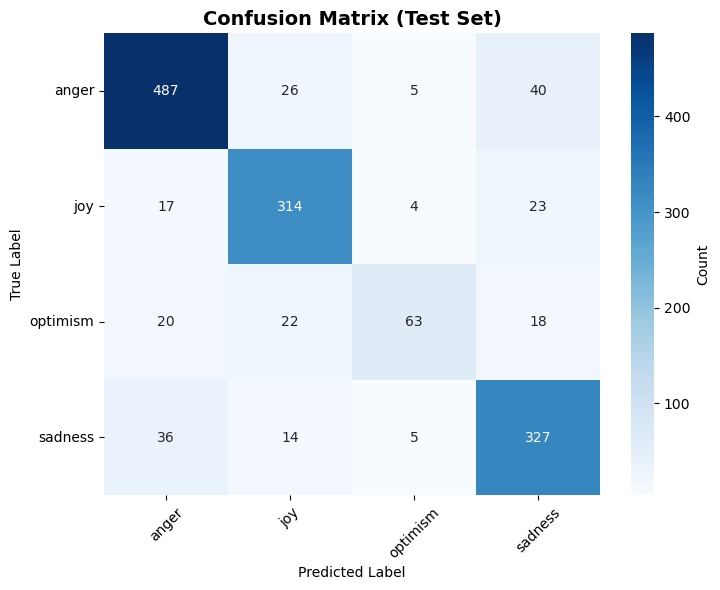

In [17]:
import seaborn as sns

def plot_confusion_matrix(test_results, emotion_labels, save_path=None):
    plt.figure(figsize=(8, 6))
    
    emotion_names = [emotion_labels[i] for i in range(len(emotion_labels))]
    conf_matrix = np.array(test_results['confusion_matrix'])
    
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='d',
                xticklabels=emotion_names,
                yticklabels=emotion_names,
                cmap='Blues',
                cbar_kws={'label': 'Count'})
    
    plt.title('Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Confusion matrix saved to: {save_path}")
    
    plt.show()

# Plot confusion matrix
conf_matrix_path = os.path.join(config.results_path, 'confusion_matrix.png')
plot_confusion_matrix(test_results, emotion_labels, save_path=conf_matrix_path)


In [22]:
print("Training Completed!!")

Training Completed!!
